In [1]:
import cpm
from packaging import version

## cpm checks
print(cpm.__version__)
if version.parse(cpm.__version__) < version.parse("0.22"):
    raise ImportError("cpm version must be >= 0.22. Please install the latest version using: pip install --upgrade cpm")

0.24.6


# Model Recovery and Landscaping (cpm.models, cpm.generators, cpm.optimisation)

We have already ran the model recovery example, which can be found in the [model-recovery-run.py](https://github.com/DevComPsy/cpm/blob/main/docs/examples/model-recovery-run.py) file. In this example, we will import the results and inspect them visually.

## Import results

In [3]:
import pandas as pd
import numpy as np

## plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("model-recovery-results.csv")

In [4]:
data = data[["target", "model", "run", "fun"]]
data


,target,model,run,fun
0,delta,delta,0,23.059331
1,delta,delta,0,26.683399
2,delta,delta,0,37.170220
3,delta,delta,0,33.120735
4,delta,delta,0,35.196873
...,...,...,...,...
21595,anticorrelated,anticorrelated,99,38.584292
21596,anticorrelated,anticorrelated,99,33.349922
21597,anticorrelated,anticorrelated,99,25.438968
21598,anticorrelated,anticorrelated,99,60.340156


In [5]:
results = data.groupby(["target", "run", "model"]).sum().reset_index()
## which model ihad the lowest fun
# For each (target, run), find which model had the lowest fun
results['lowest_fun_model'] = results.groupby(['target', 'run'])['fun'].transform(lambda x: x.idxmin())
results['is_lowest'] = results.index == results['lowest_fun_model']
results[['target', 'run', 'model', 'fun', 'is_lowest']]

,target,run,model,fun,is_lowest
0,anticorrelated,0,anticorrelated,866.239182,True
1,anticorrelated,0,delta,1038.793504,False
2,anticorrelated,0,kernel,1051.874477,False
3,anticorrelated,1,anticorrelated,925.886793,True
4,anticorrelated,1,delta,1073.461200,False
...,...,...,...,...,...
895,kernel,98,delta,1082.442799,True
896,kernel,98,kernel,1084.175883,False
897,kernel,99,anticorrelated,965.265362,False
898,kernel,99,delta,866.880823,False


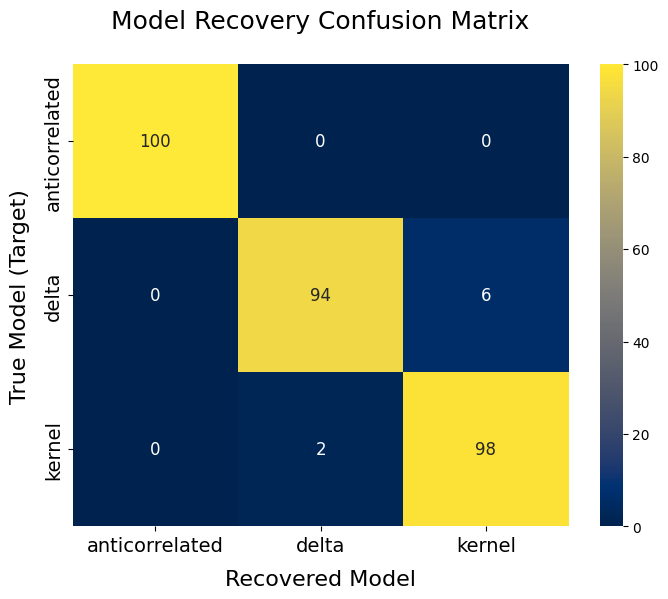

In [6]:
confusion_matrix = results[results.is_lowest == True].groupby(['target']).model.value_counts().astype('double').reset_index().pivot(index='target', columns='model', values='count').fillna(0).astype(int).reset_index()
plt.figure(figsize=(8, 6))
sns.heatmap(
    confusion_matrix.set_index('target'),
    annot=True,
    fmt='d',
    cmap='cividis',
    annot_kws={"size": 12}
)
plt.title('Model Recovery Confusion Matrix\n', fontsize=18)
plt.ylabel('True Model (Target)', fontsize=16, labelpad=10)
plt.xlabel('Recovered Model', fontsize=16, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Landscaping analysis

Landscaping (Navarro et al., 2004) is a technique that allows to systematically explore the performance of different models on a dataset generated by one of them. It is part of a group of global model analysis techniques, that is designed to step back from a particular data sample and focus on the behavior of the model as a whole. Landscaping adds another dimension to fits to data by increasing our understanding of the models and data.

At its core, landscaping provides a visual representation of how two models relate to each other and experimental data. This is done by fitting one model to many datasets generated by that model under a specific experimental design. Another model is then fit to these same datasets, and the fits from both models are plotted against each other. The resulting scatterplot is known as a landscape.

In [18]:
landscaping = data
pivoted = landscaping.pivot_table(index=['target', 'run'], columns='model', values='fun').reset_index()

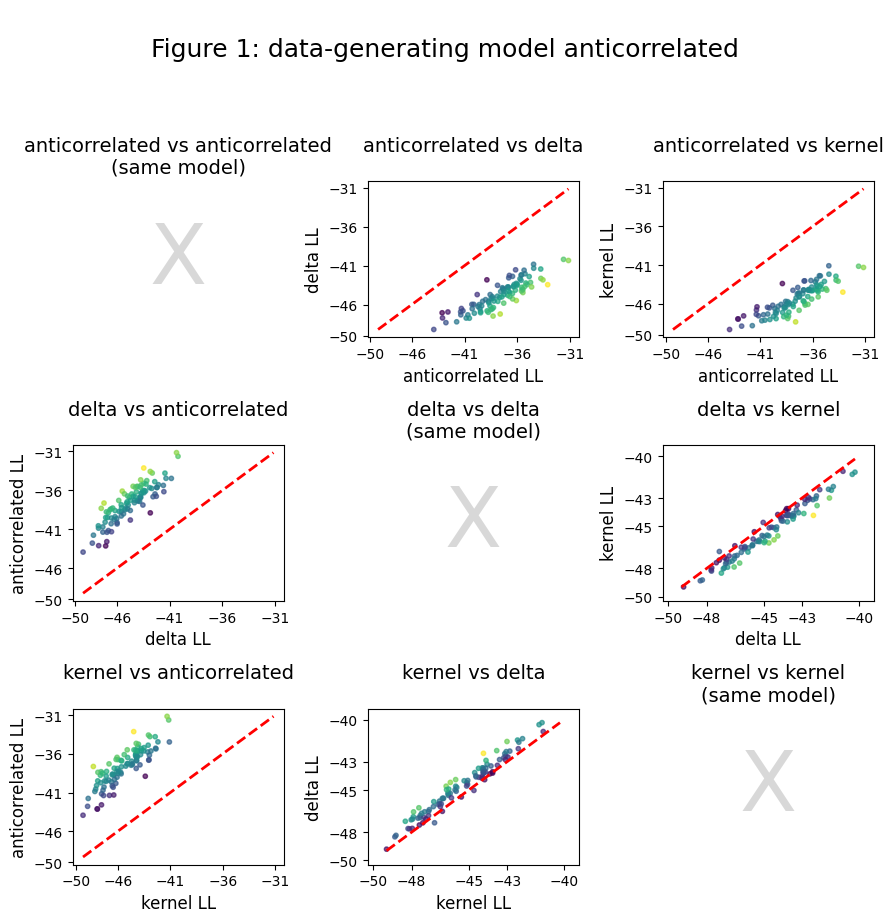

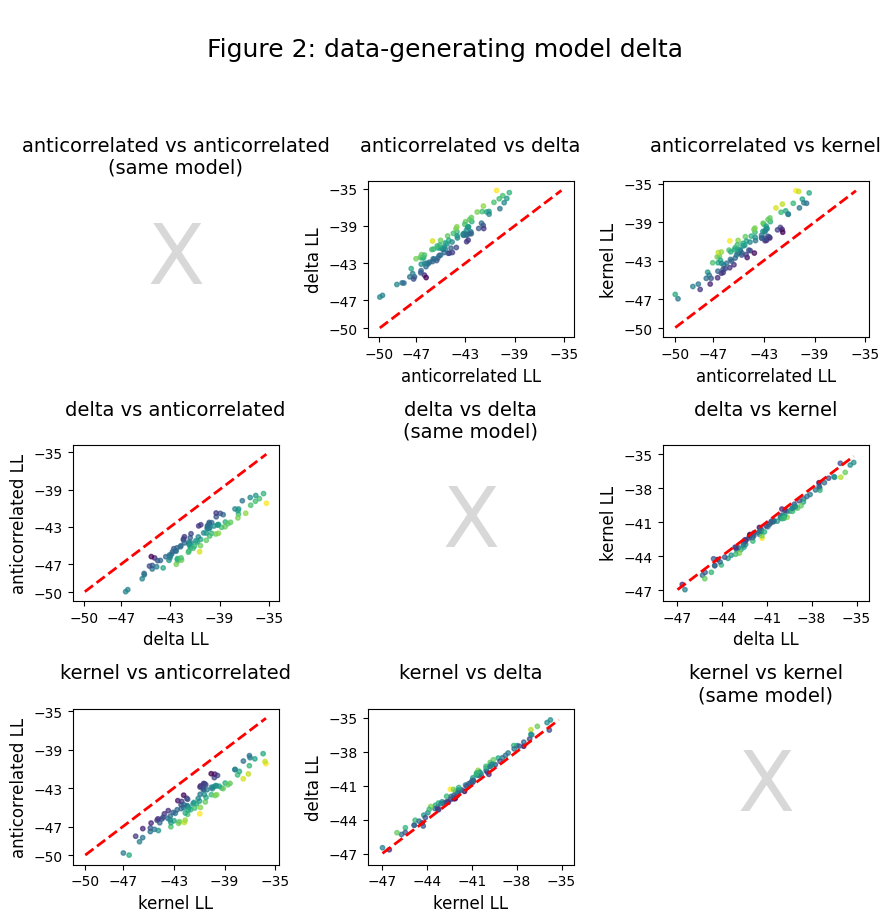

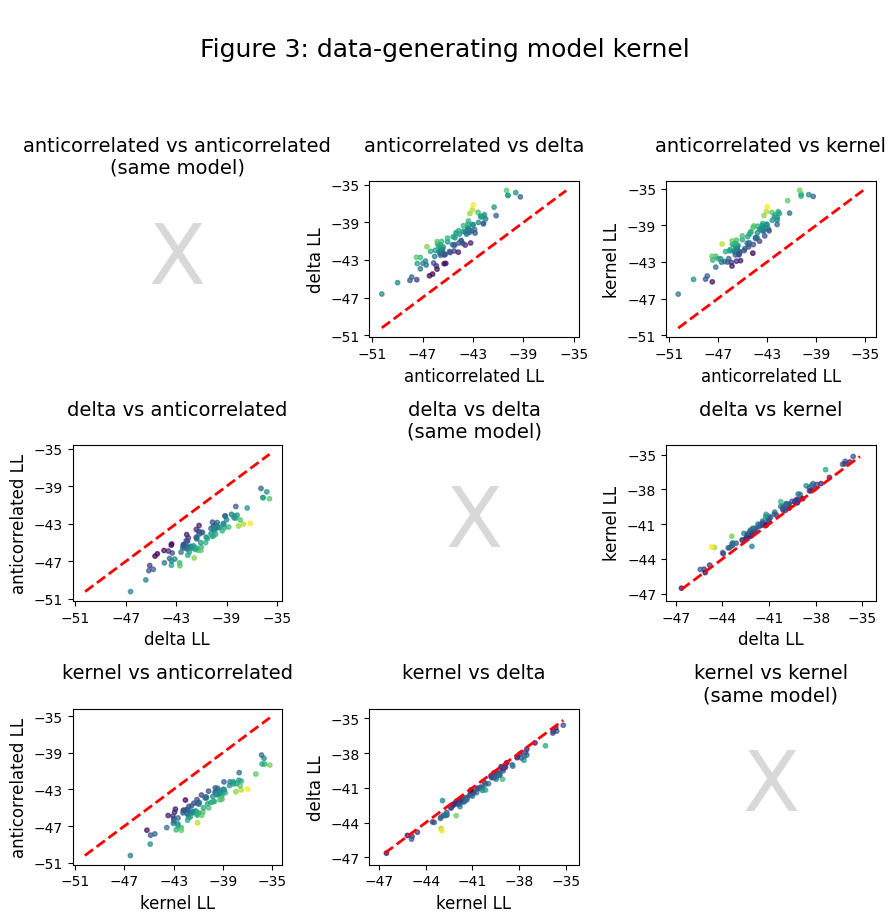

In [55]:
model_names = ['anticorrelated', 'delta', 'kernel']
num_models = len(model_names)

for index, target in enumerate(results['target'].unique()):
    subset = pivoted[pivoted['target'] == target]
    fig, axes = plt.subplots(num_models, num_models, figsize=(3*num_models, 3*num_models), squeeze=False)
    for i, x_model in enumerate(model_names):
        for j, y_model in enumerate(model_names):
            ax = axes[i, j]
            if x_model == y_model:
                ax.text(0.5, 0.5, 'X', fontsize=60, color='gray', ha='center', va='center', alpha=0.3, transform=ax.transAxes)
                ax.axis('off')
                ax.set_title(f"{x_model} vs {y_model}\n(same model)", fontsize=14)
                continue
            x = -subset[x_model]
            y = -subset[y_model]
            distance = np.abs(x - y)
            scatter = ax.scatter(x, y, c=distance, cmap='viridis', alpha=0.7, s=10)
            min_val = min(x.min(), y.min())
            max_val = max(x.max(), y.max())
            ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)
            ax.set_xlabel(f"{x_model} LL", fontsize=12)
            ax.set_ylabel(f"{y_model} LL", fontsize=12)
            ax.set_title(f"{x_model} vs {y_model}\n", fontsize=14)
            # Set same limits and ticks
            ax.set_xlim(min_val-1, max_val + 1)
            ax.set_ylim(min_val-1, max_val + 1)
            ticks = np.linspace(int(np.floor(min_val)), int(np.ceil(max_val)), num=5, dtype=int)
            ax.set_xticks(ticks)
            ax.set_yticks(ticks)
    fig.suptitle(f"\nFigure {index + 1}: data-generating model {target}", fontsize=18, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


Let us look at the results on Figure 3. First thing to notice is that now we are plotting the Log Likelihoods and not the negative Log Likelihoods. So the bigger the number the better the fit. The data-generating model is the kernel model, so we expect the fits to move towards the kernel axis and away from the anticorrelated and delta models.

The bottom left corner of Figure 3 shows the anticorrelated model fit against the kernel model fit. There is a big shift away from the diagonal line, which indicates that the two models are qualitatively distinguishable and the data is informative enough to decide between them meaningfully. And as it comes, the kernel model wins over the  anticorrelated model.

On the other hand, let us look at the bottom middle plot on Figure 3. The kernel and delta models are very similar, and the fits are very close to the diagonal line, with a slight shift towards the kernel model (e.g. the kernel was better at fitting), but this is a small shift. This suggests that there is little chance of finding discriminating data for these two models.

## References

Navarro, D. J., Pitt, M. A., & Myung, I. J. (2004). Assessing the distinguishability of models and the informativeness of data. Cognitive Psychology, 49(1), 47–84. https://doi.org/10.1016/j.cogpsych.2003.11.001


## Appendix: Model Descriptions

